
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/justinhou95/DeepHedging/blob/main/deep%20efficient%20hedging.ipynb)


In [1]:
# import sys
# import os 
# if '/content' in sys.path:
#     if 'DeepHedging' in os.listdir():
#         !rm -rf DeepHedging/
#     !git clone https://github.com/justinhou95/DeepHedging/  
#     import sys
#     path = '/content/DeepHedging'
#     if path not in sys.path:
#         sys.path.append('/content/DeepHedging')

In [2]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras
import utils.utils_efficient as utils_efficient
from importlib import reload 
print(tf.__version__)
reload(utils_efficient)

2.3.0


<module 'utils.utils_efficient' from 'C:\\SongyanHou\\Study\\Codes\\DeepHedging\\utils\\utils_efficient.py'>

In [3]:
class EfficientHedge:
    def __init__(self, po):
        self.po = po
        self.N = 100 # time disrectization    
        self.S0 = 1.0 # initial value of the asset
        self.T = 0.25 # maturity
        self.dt = self.T / 100
        self.strike = 1.1
        self.payoff_function = lambda x : 0.5*(np.abs(x-self.strike)+x-self.strike) # European call option payoff
        self.option_type = 'eurocall'
        self.strike_modified = 1.3
        
        if po == np.inf:
            self.payoff_function_modified = lambda x : 0.5*(np.abs(x-self.strike_modified)+x-self.strike_modified) 
            def ploss(payoff, outputs):
                loss = tf.math.reduce_max(tf.nn.relu(payoff - outputs),keepdims = True)
                return loss
        if po == 1:
            self.payoff_function_modified = lambda x : (x-self.strike) * (x > self.strike_modified) 
            def ploss(payoff, outputs):
                loss = (tf.nn.relu(payoff - outputs))**po
                return loss
        if po == 0:
            self.payoff_function_modified = lambda x : (x-self.strike) * ((x < self.strike_modified) & (x > self.strike))
            def ploss(payoff, outputs):
                loss = tf.math.sign(tf.nn.relu(payoff - outputs))
                return loss
        self.ploss = ploss

    def generate_data(self):        
        self.m = 1 # dimension of price
        self.mu = 0.02
        self.sigma = 0.3
        self.Ktrain = 10**5
        self.price_path, self.time_grid = utils_efficient.simulate_GBM(self.m,self.Ktrain,self.N,self.T,\
                                                             self.mu,self.sigma,self.S0, 'equi')
        self.price_path_EMM, _ = utils_efficient.simulate_GBM(self.m,self.Ktrain,self.N,self.T,\
                                                             0,self.sigma,self.S0, 'equi')
        self.payoff = self.payoff_function(self.price_path[:,-1]) 
        self.payoff_modified = self.payoff_function_modified(self.price_path[:,-1]) 
        if self.po == np.inf:
            self.delta_output, self.delta_path, self.option_path = utils_efficient.delta_hedge(self.price_path,self.payoff_modified,self.T,self.strike_modified,self.sigma,self.option_type,self.time_grid)
            self.initial_wealth,_ = utils_efficient.BlackScholes(self.T, self.S0, self.strike_modified, self.sigma, self.option_type)
        else:
            self.delta_output, self.delta_path, self.option_path = utils_efficient.delta_hedge(self.price_path,self.payoff_modified,self.T,\
                                                                                               [self.strike, self.strike_modified],self.sigma,self.po,self.time_grid)
#             self.initial_wealth = self.payoff_function_modified(self.price_path_EMM[:,-1]).mean() ###### EMM
            self.initial_wealth = self.option_path[0,0,0]
            
    def plot_payoff(self):
        print(f"real premium: {self.initial_wealth:{1}.{4}}")           # real premium
        f,p = plt.subplots(1,2, figsize = [10,3], sharey = True)
        p[0].scatter(self.price_path[:,-1,0], self.payoff[:,0], s = 1, alpha = 0.5, label = 'payoff')
        p[1].scatter(self.price_path[:,-1,0], self.payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff')
        p[0].grid()
        p[1].grid()
        plt.show()
    def build_model(self):
        self.model_hedge, self.Network0, self.Networks = build_dynamic(self.m, self.N, False, False, self.initial_wealth, self.po, self.ploss)
    def prepare_data(self):    
        control_path = False
        if not control_path:
            self.split = int(self.Ktrain/2)
            self.xtrain = [self.price_path[:self.split], self.payoff[:self.split]]  # input be price_path
            self.ytrain = self.payoff[:self.split]*0  # output be payoff
            self.xtest = [self.price_path[self.split:], self.payoff[:self.split]]  # input be price_path
            self.ytest = self.payoff[self.split:]*0  # output be payoff    
        else:
            self.split = int(self.Ktrain/2)
            self.xtrain = [self.price_path[:self.split], self.payoff[:self.split], self.option_path[:self.split]]  # input be price_path
            self.ytrain = self.payoff[:self.split]*0  # output be payoff
            self.xtest = [self.price_path[self.split:], self.payoff[:self.split], self.option_path[self.split:]]  # input be price_path
            self.ytest = self.payoff[self.split:]*0  # output be payoff    
    def train(self):
        def zeroloss(y_true, y_predict):
            return tf.reduce_sum(y_predict*0)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
        # model_hedge.compile(optimizer = optimizer,loss='mse') # specify the mean square loss 
        self.model_hedge.compile(optimizer = optimizer,loss=zeroloss) # specify the expected shortfall
        self.model_hedge.fit(x=self.xtrain,y=self.ytrain, epochs=10,verbose=True,batch_size=256) # train the model
    def predict(self):
        self.hedge_output_train = self.model_hedge.predict(self.xtrain) # compute the output (deep replicate payoff) with trained model 
        self.hedge_output_test = self.model_hedge.predict(self.xtest) # compute the output (deep replicate payoff) with trained model
        print('train: ',tf.reduce_mean(self.ploss(self.payoff[:self.split], self.hedge_output_train)).numpy())
        print('test: ',tf.reduce_mean(self.ploss(self.payoff[self.split:], self.hedge_output_test)).numpy())
        print('best: ',tf.reduce_mean(self.ploss(self.payoff, self.delta_output)).numpy())
        
        f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
        p[0].scatter(self.price_path[self.split:,-1,0], self.hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')   # deep replicate payoff 
        p[1].scatter(self.price_path[:self.split,-1,0], self.hedge_output_train[:,0], s = 1, alpha = 0.5, label = 'deep hedge train')   # deep replicate payoff 
        if self.po == np.inf:
            p[2].scatter(self.price_path[:,-1,0], self.delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
        if self.po == 0:
            p[2].scatter(self.price_path[:,-1,0], self.delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
        
        for i in range(3):
            p[i].scatter(self.price_path[:,-1,0], self.payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
            p[i].scatter(self.price_path[:,-1,0], self.payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff')
            
            p[i].legend()
            p[i].grid()
    def compare_strategy(self):
        f,p = plt.subplots(1,5,figsize = [20,5])
        for i in range(5):
            n = 20*i + 10
            pr = np.linspace(0.5,2,100)[:,None]  # tf.tensor of different price 

            he = self.Networks[n](tf.math.log(pr)) # the stategy network 
            p[i].plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy
            if self.po == np.inf:
                _ , delta = utils_efficient.BlackScholes(self.T - self.time_grid[n], pr, self.strike_modified, self.sigma, self.option_type)
                p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
            if self.po == 0:
                _ , delta = utils_efficient.BS0(self.T - self.time_grid[n], pr, [self.strike,self.strike_modified], self.sigma, self.option_type)
                p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
            p[i].title.set_text(f"At time: {self.time_grid[n]:{1}.{4}}")
            p[i].legend()
            p[i].grid()
        plt.show()
        

### Build the deep hedging dynamic 

<!-- Value process
$$
V_{t} = \int_{0}^{t}H_{t}dS_{t} + \alpha \int_{0}^{t}(S_{t}dH_{t})^{2} \cdot \text{(trans_cost =True)}
$$
Objective function
\begin{equation}
\begin{split}
\min_{H_{t}}\quad & E\bigg[(f(S_{T})-V_{T})^2\bigg] \\
+ &\beta E\bigg[\int_{0}^{T}(C_{t} - V_{t})^{2}dt\bigg] \cdot \text{(control_path =True)}
\end{split}
\end{equation}

where $(C_{t})_{t\geq 0}$ is the call option price and $f$ is the payoff function. -->

In [4]:
def build_dynamic(m, N, control_path, trans_cost, initial_wealth, po, ploss):
    
    L = 3 # number of layers in strategy
    n = m + 20  # nodes in the first but last layers
    Networks = utils_efficient.build_network(m, n , L, N)
    Network0 = keras.layers.Dense(1, use_bias=False)

    price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
    benchmark_hedge = keras.Input(shape=(N+1,m))   # V_{t}; t=0,..,N+1; (batch, N+1, m)
    payoff = keras.Input(shape=(1))
    if control_path:
        inputs = [price, payoff, benchmark_hedge]
    else:
        inputs = [price, payoff]
    price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
#     premium = Network0(tf.ones_like(price[:,0,:1])) # premium; (batch, 1)
    premium = initial_wealth

    HEDGE = [None]*(N+1)
    HEDGE[0] = tf.zeros_like(price[:,0,:])
    STRATEGY = [None]*N
    ADMISSIBLE = tf.zeros_like(price[:,0,:])
    
    for j in range(N):
        I = tf.math.log(price[:,j,:])
        STRATEGY[j] = Networks[j](I) # H_{t} = nn(S_{t}); (batch, m)
        cost = 0
        if trans_cost and j > 0: 
            cost = 0.005*((STRATEGY[j]- STRATEGY[j-1])*price[:,j,:])**2
            
        HEDGE[j+1] = HEDGE[j] + STRATEGY[j] * price_difference[:,j,:] - cost # dX_{t} = H_{t}dS_{t}; (batch, m)
        ADMISSIBLE = tf.math.minimum(ADMISSIBLE, HEDGE[j+1] + premium)
      
    outputs = premium + tf.math.reduce_sum(HEDGE[-1],axis = -1, keepdims = True) # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)    
    model_hedge = keras.Model(inputs = inputs, outputs=outputs)

# Define LOSS

#     mse = tf.keras.losses.MeanSquaredError()
#     model_hedge.add_loss(mse(outputs, payoff))   

#     alpha = 0.99
#     loss = premium + 1/(1 - alpha)*tf.nn.relu(payoff - outputs)
#     loss = tf.reduce_mean(loss)
#     model_hedge.add_loss(loss)  

    loss = ploss(payoff, outputs)
    loss = tf.clip_by_value(loss,0,10000) 
    model_hedge.add_loss(tf.reduce_mean(loss)) 
    
    loss = tf.math.sign(-ADMISSIBLE)
    loss = -ADMISSIBLE*50
    loss = tf.clip_by_value(loss,0,10000)
    model_hedge.add_loss(tf.reduce_mean(loss)) 
    model_hedge.add_metric(loss, name='0-ad-loss')
    
    loss = tf.nn.relu((outputs - payoff)*10)
    loss = tf.clip_by_value(loss,0,10000)
    model_hedge.add_loss(tf.reduce_mean(loss)) 
    model_hedge.add_metric(loss, name='up-ad-loss')
    
    if control_path:
        for j in range(N):
            mse = tf.keras.losses.MeanSquaredError()
            model_hedge.add_loss(10*mse(HEDGE[j]+premium, benchmark_hedge[:,j]))   
    
    return model_hedge, Network0, Networks


real premium: 0.002766


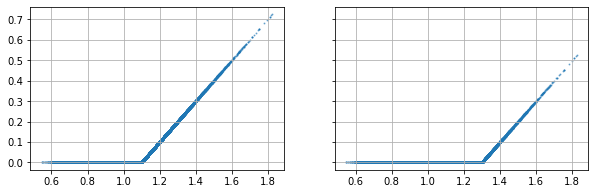

Epoch 1/10
196/196 [==============================] - 15s 75ms/step - loss: 0.5418 - 0-ad-loss: 0.2471 - up-ad-loss: 0.0183
Epoch 2/10
196/196 [==============================] - 15s 77ms/step - loss: 0.3979 - 0-ad-loss: 0.1272 - up-ad-loss: 0.0107
Epoch 3/10
196/196 [==============================] - 15s 76ms/step - loss: 0.3526 - 0-ad-loss: 0.0862 - up-ad-loss: 0.0087
Epoch 4/10
196/196 [==============================] - 15s 76ms/step - loss: 0.3319 - 0-ad-loss: 0.0704 - up-ad-loss: 0.0075
Epoch 5/10
196/196 [==============================] - 15s 77ms/step - loss: 0.3196 - 0-ad-loss: 0.0630 - up-ad-loss: 0.0070
Epoch 6/10
196/196 [==============================] - 15s 76ms/step - loss: 0.3055 - 0-ad-loss: 0.0514 - up-ad-loss: 0.0066
Epoch 7/10
196/196 [==============================] - ETA: 0s - loss: 0.3061 - 0-ad-loss: 0.0507 - up-ad-loss: 0.00 - 15s 77ms/step - loss: 0.3060 - 0-ad-loss: 0.0507 - up-ad-loss: 0.0064
Epoch 8/10
196/196 [==============================] - 16s 81ms/step 

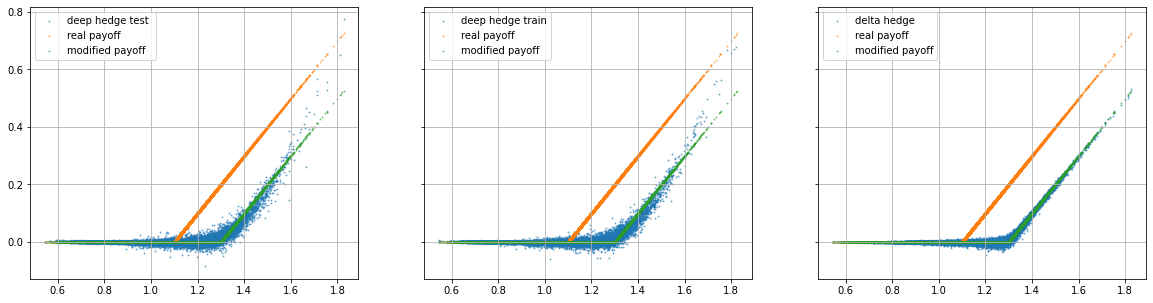

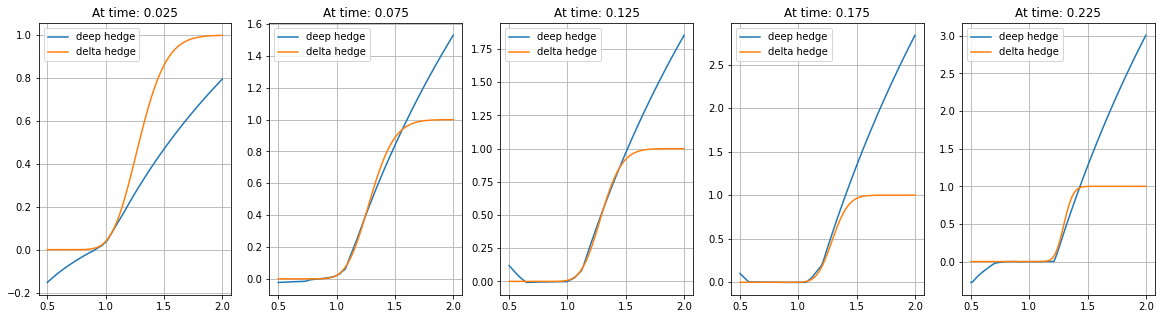

In [12]:
efficient_hedge_inf = EfficientHedge(np.inf)
efficient_hedge_inf.generate_data()
efficient_hedge_inf.plot_payoff()
efficient_hedge_inf.build_model()
efficient_hedge_inf.prepare_data()
efficient_hedge_inf.train()
efficient_hedge_inf.predict()
efficient_hedge_inf.compare_strategy()

real premium: 0.00958


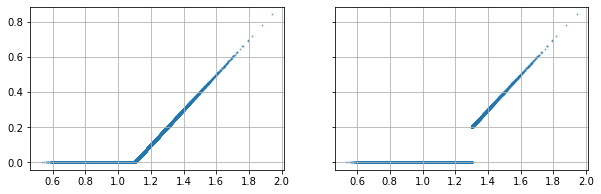

Epoch 1/10
196/196 [==============================] - 12s 61ms/step - loss: 0.1228 - 0-ad-loss: 0.0483 - up-ad-loss: 0.0526
Epoch 2/10
196/196 [==============================] - 12s 61ms/step - loss: 0.0719 - 0-ad-loss: 0.0137 - up-ad-loss: 0.0379
Epoch 3/10
196/196 [==============================] - 12s 62ms/step - loss: 0.0631 - 0-ad-loss: 0.0111 - up-ad-loss: 0.0323
Epoch 4/10
196/196 [==============================] - 12s 61ms/step - loss: 0.0558 - 0-ad-loss: 0.0089 - up-ad-loss: 0.0277
Epoch 5/10
196/196 [==============================] - 12s 61ms/step - loss: 0.0527 - 0-ad-loss: 0.0084 - up-ad-loss: 0.0253
Epoch 6/10
196/196 [==============================] - 12s 60ms/step - loss: 0.0503 - 0-ad-loss: 0.0077 - up-ad-loss: 0.0238
Epoch 7/10
196/196 [==============================] - 11s 57ms/step - loss: 0.0480 - 0-ad-loss: 0.0066 - up-ad-loss: 0.0226
Epoch 8/10
196/196 [==============================] - 12s 61ms/step - loss: 0.0471 - 0-ad-loss: 0.0068 - up-ad-loss: 0.0217
Epoch 9/

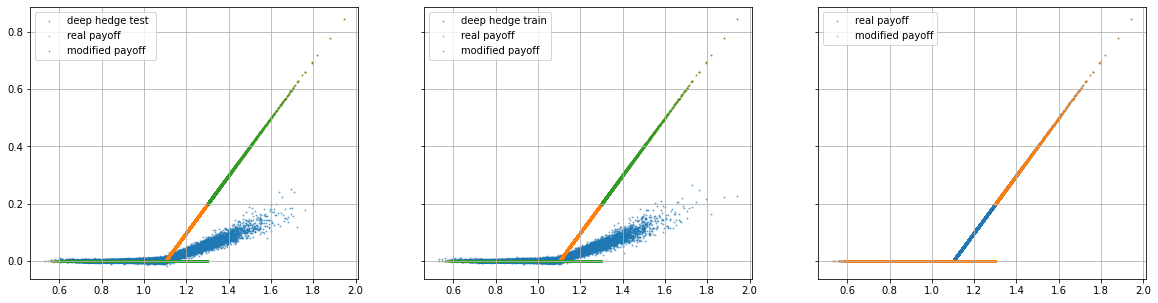

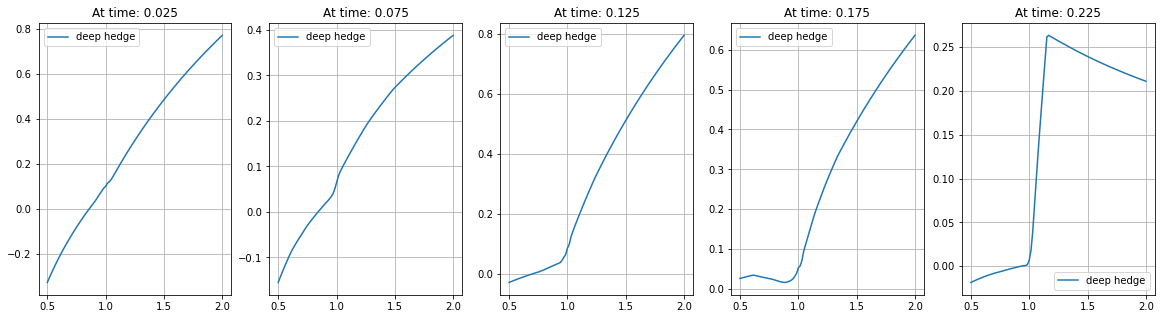

In [5]:
efficient_hedge_1 = EfficientHedge(1)
efficient_hedge_1.generate_data()
efficient_hedge_1.plot_payoff()
efficient_hedge_1.build_model()
efficient_hedge_1.prepare_data()
efficient_hedge_1.train()
efficient_hedge_1.predict()
efficient_hedge_1.compare_strategy()

real premium: 0.01542


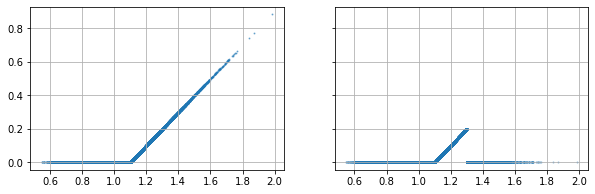

Epoch 1/10
196/196 [==============================] - 5s 27ms/step - loss: 0.5511 - 0-ad-loss: 0.0217 - up-ad-loss: 0.0344
Epoch 2/10
196/196 [==============================] - 6s 31ms/step - loss: 0.5390 - 0-ad-loss: 0.0137 - up-ad-loss: 0.0216
Epoch 3/10
196/196 [==============================] - 6s 33ms/step - loss: 0.5355 - 0-ad-loss: 0.0117 - up-ad-loss: 0.0189
Epoch 4/10
196/196 [==============================] - 6s 32ms/step - loss: 0.5351 - 0-ad-loss: 0.0107 - up-ad-loss: 0.0174 0s - loss: 0.5360 - 0-ad-loss: 0.0109 
Epoch 5/10
196/196 [==============================] - 6s 29ms/step - loss: 0.5391 - 0-ad-loss: 0.0104 - up-ad-loss: 0.0162
Epoch 6/10
196/196 [==============================] - 6s 29ms/step - loss: 0.5351 - 0-ad-loss: 0.0098 - up-ad-loss: 0.0159
Epoch 7/10
196/196 [==============================] - 6s 30ms/step - loss: 0.5376 - 0-ad-loss: 0.0100 - up-ad-loss: 0.0156
Epoch 8/10
196/196 [==============================] - 6s 29ms/step - loss: 0.5363 - 0-ad-loss: 0.009

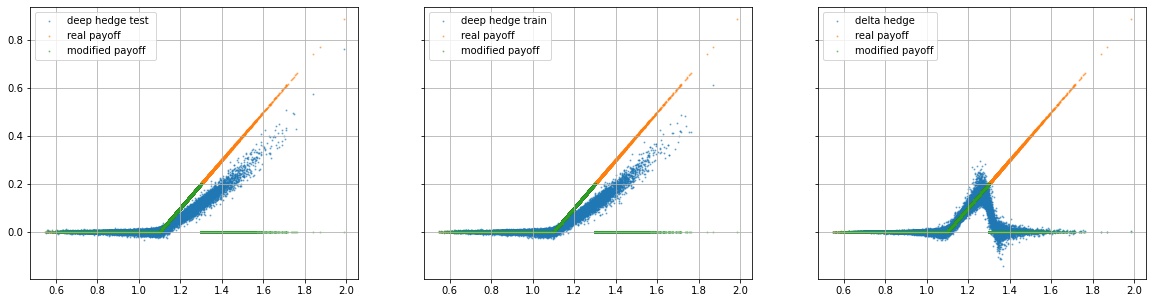

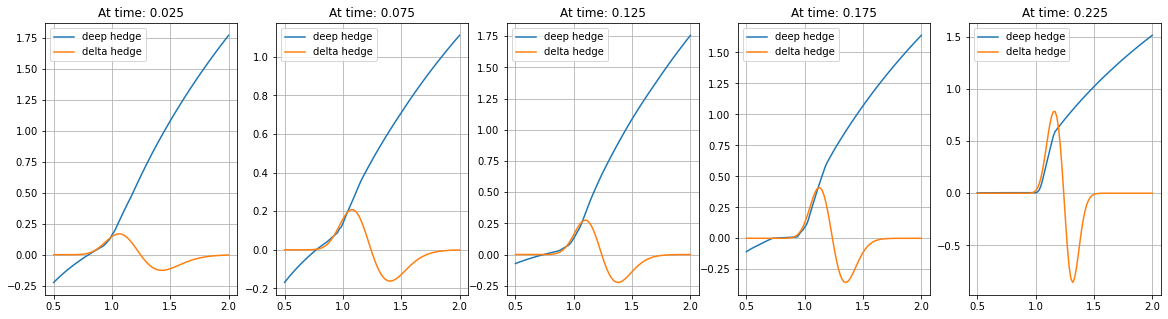

In [8]:
efficient_hedge_0 = EfficientHedge(0)
efficient_hedge_0.generate_data()
efficient_hedge_0.plot_payoff()
efficient_hedge_0.build_model()
efficient_hedge_0.prepare_data()
efficient_hedge_0.train()
efficient_hedge_0.predict()
efficient_hedge_0.compare_strategy()

In [43]:
def train_loss(model):
    l = tf.reduce_mean(model.ploss(model.payoff, model.delta_output)).numpy() 
    l += 50*tf.reduce_mean(tf.nn.relu(-tf.reduce_min(model.delta_path, axis = 1))).numpy()
    l += tf.reduce_mean(tf.nn.relu((model.delta_output - model.payoff)*10)).numpy()
    return l
print(train_loss(efficient_hedge_0))
efficient_hedge_0.model_hedge.evaluate(efficient_hedge_0.xtrain,efficient_hedge_0.ytrain)
efficient_hedge_0.model_hedge.evaluate(efficient_hedge_0.xtest,efficient_hedge_0.ytest)

0.5736329125672066
1563/1563 [==============================] - ETA: 0s - loss: 0.6217 - 0-ad-loss: 0.0115 - up-ad-loss: 0.14 - 15s 9ms/step - loss: 0.6218 - 0-ad-loss: 0.0115 - up-ad-loss: 0.1417


[0.621806800365448, 0.011484891176223755, 0.1417222023010254]

### History

In [ ]:
# print(f"deep premium: {Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{4}}")         # premium of deep hedge (truncted printing)
# helper,_ = utils_efficient.BlackScholes(T, S0, strike, sigma, option_type)
# print(f"real premium: {helper:{1}.{4}}")           # real premium

In [ ]:
# plt.hist(hedge_output_train[:,0] - ytrain[:,0],bins = 100)
# plt.show()

In [ ]:
# f,p = plt.subplots(1,5,figsize = [20,5])
# for i in range(5):
#     n = 20*i + 10
#     pr = np.linspace(0.5,2,100)[:,None]  # tf.tensor of different price 

#     he = Networks[n](pr) # the stategy network 
#     p[i].plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy

#     _,delta = utils_efficient.BlackScholes(T - time_grid[n], pr, strike, sigma, option_type)
#     p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
#     p[i].title.set_text(f"At time: {time_grid[n]:{1}.{4}}")
#     p[i].legend()
#     p[i].grid()
# plt.show()

In [ ]:
# Hedge = [None] * N
# transaction_cost = 0
# for j in range(N):
#     Hedge[j] = Networks[j](price_path[:,j,:])
#     if j > 0: 
#         transaction_cost += 0.005*(Hedge[j]*price_path[:,j-1,:] - Hedge[j-1]*price_path[:,j-1,:])**2
# print(transaction_cost[:,0].numpy().mean())
# plt.hist(transaction_cost[:,0].numpy())